# Global indicator project - Phoenix, Arizona

## local neighborhood network accessibility analysis - amenities pois
This notebook uses sausage buffer intersection approach to calculate the accessibility score of sample point local neighborhood. This process use hard threshold distance to count whether any pois (in this case, it is frequent bus stops) located within the local walkable neighborhoods.

### Process:
1. Load frequent bus stop data from folder
2. Get sample point local neighborhood (sausage buffer)
3. Local neighbothood with at least one amenity pois intersecting
    - the output results are geoseries of local neighborhood buffer polygon
4. Connect the result to sample point dataframe
    - accessibility score is calculated as 1=at least one pois is within the local walkable neighborhood; 0=none of the pois is within the local walkable neighborhood.




In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import numpy as np
import requests
import pandas as pd
import geopandas as gpd
import os
import time 
from shapely.geometry import shape,Point, LineString, Polygon


import pandana
from pandana.loaders import osm

ox.config(use_cache=True, log_console=True)
pandana.__path__ #pandana runs on python 3.6 kernel

/Users/NGAU/miniconda3/envs/ind_global/lib/python3.6/site-packages/pandana/network.py:5: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/NGAU/miniconda3/envs/ind_global/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/NGAU/miniconda3/envs/ind_global/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/NGAU/miniconda3/envs/ind_global/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/NGAU/miniconda3/envs/ind_global/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/NGAU/minicon

['/Users/NGAU/miniconda3/envs/ind_global/lib/python3.6/site-packages/pandana']

## Set up configuration 

In [2]:
place = 'phoenix' 

region = 'Arizona, USA' # study region name

studyregion = 'Phoenix, Arizona, USA'

suffix = '_201905'

pois = 'frequent bus stops'

# configure filenames to save/load POI and network datasets
OSM_folder = '../data/OSM'

G_filename = '{studyregion}_walk{suffix}.graphml'.format(studyregion = studyregion, suffix = suffix)
G_proj_filename='{studyregion}_proj_walk{suffix}.graphml'.format(studyregion = place, suffix = suffix)

frequent_stop_filepath = "../data/Transport/gtfs_phx/stop_30_mins_bus_final.csv"
G_filepath = OSM_folder + "/" + G_filename
sample_points_filepath = '../data/OSM/phoenix_testing_sample_points_201905/phoenix_testing_sample_points_201905.shp'
sample_points_stats_filepath = '../data/OSM/phoenix_sample_points_stats_201905.csv'

In [3]:
# get bounding box from study region boundary shapefile
shape_filepath = '../data/OSM/Phoenix, Arizona, USA_buffered_201905/Phoenix, Arizona, USA_buffered_201905.shp'

gdf_shape = gpd.GeoDataFrame.from_file(shape_filepath)
bbox = [gdf_shape['bbox_south'].astype(float)[0], gdf_shape['bbox_west'].astype(float)[0], gdf_shape['bbox_north'].astype(float)[0], gdf_shape['bbox_east'].astype(float)[0]] #lat-long bounding box for Phx
bbox

[33.2903739, -112.3240289, 33.9183794, -111.9255201]

## Load frequent bus stop data from folder

In [4]:
bus_stop_gdf = gpd.GeoDataFrame.from_csv(frequent_stop_filepath)
bus_stop_gdf = gpd.GeoDataFrame(bus_stop_gdf)
bus_stop_gdf['geometry'] = bus_stop_gdf.apply(lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
bus_stop_gdf = bus_stop_gdf.rename(columns={'stop_lat':'lat', 'stop_lon':'lon'})

bus_stop_gdf.head()

/Users/NGAU/miniconda3/envs/ind_global/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


,route_type,stop_id,stop_name,lat,lon,geometry
0,3,7125,Van Buren St & 21st Av,33.451319,-112.105049,POINT (-112.1050493 33.45131936)
1,3,20011,40th St & Elwood St,33.414488,-111.995519,POINT (-111.9955192 33.41448848)
2,3,9384,40th St & Cholla St,33.589620,-111.995879,POINT (-111.9958789 33.58961953)
3,3,3797,24th St & Campbell Av,33.501490,-112.030343,POINT (-112.0303433 33.50149027)
4,3,30139,Ray Rd & Hamilton St,33.320840,-111.833390,POINT (-111.83339 33.32084)


In [5]:
# define pois points projection
bus_stop_gdf.crs = {'init' :'epsg:4326'}
bus_stop_gdf = ox.project_gdf(bus_stop_gdf)

## Get sample point local neighborhood (sausage buffer)

In [6]:
# load sample point geodataframe
sample_points = gpd.GeoDataFrame.from_file(sample_points_filepath)
sample_points.shape

(100, 22)

In [7]:
# load study region projected graph
# we load the projected graph because the sample point geometry is in a projected coordinate system
G_proj = ox.load_graphml(G_proj_filename, folder=OSM_folder)

In [8]:
# create list of sample points to iterate over
point_locations = []

for point in sample_points.geometry: 
    point = (point.x, point.y)
    point_locations = point_locations + [point]

In [9]:
# create sausage buffer local neighborhood geodataframe
def create_sausage_buffer_gdf(G_proj, orig_point, buffer=50, length = 1600, intersection_tolerance = 15):
    # locate closest node on network to 
    orig_node = ox.get_nearest_node(G_proj, orig_point, return_dist=True)
    subgraph_proj = nx.ego_graph(G_proj, orig_node[0], radius=length, distance='length')
    subgraph_gdf = ox.graph_to_gdfs(subgraph_proj, nodes=False, edges=True, fill_edge_geometry=True)
    # create buffer polygon geometry to dataframe
    subgraph_gdf['geometry'] = subgraph_gdf.geometry.buffer(buffer) 
    #link original node id reference
    subgraph_gdf['node_id'] = orig_node[0]
    return(subgraph_gdf) #output is smaple point subgraph with buffer polygon geometry and original node id reference

In [10]:
# iterate over a list of sample points to create sausage buffer as local walkable neighborhood
start = time.time()
task = 'Buffer network for {} sample points'.format(len(point_locations))
sausagebuffers = []
for point in point_locations:
    sausagebuffers.append(create_sausage_buffer_gdf(G_proj, point))
print('Completed task "{}" in {:,.2f} seconds'.format(task,time.time() - start)) 

Completed task "Buffer network for 100 sample points" in 176.94 seconds


## POIs point and sausage buffer intersection

In [11]:
# make sure pois geometry is in the same projection as the sausage buffer geometry
bus_stop_gdf = bus_stop_gdf.to_crs(sausagebuffers[0].crs)
bus_stop_gdf.crs == sausagebuffers[0].crs

True

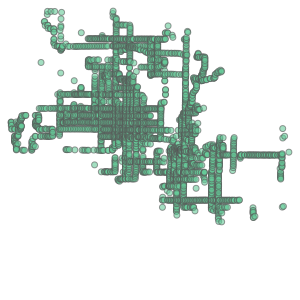

In [12]:
bus_stop_gdf.geometry.unary_union

In [13]:
def get_nodeid_pois_sausagebuffer_intersection(sausagebuffer_gdf, pois_gdf):
    # make sure sausagebuffer and pois_gdf is in the same projection system
    # create an empty list
    buffer_node_id = pd.DataFrame()
    # loop through sausage buffer intersection with pois
    for x in range(0, len(sausagebuffer_gdf)):
        buffer_node_id1 = pd.DataFrame()
        #Returns a Series of dtype('bool') with value True for each polygon geometry that intersects other.
        pois_intersect = sausagebuffer_gdf[x].geometry.intersects(pois_gdf['geometry'].unary_union) 
        # return a dataframe with pois within local walkable neighborhood (pois intersecting buffer), 
        # retain orignal node id for reference in sample point neighborhood
        buffer_node_id1['pois_walkable_node_id'] = [sausagebuffer_gdf[x][pois_intersect]['node_id'].max()]
        buffer_node_id = buffer_node_id.append(buffer_node_id1, ignore_index=True).dropna().astype(int)
        intersection_node_id = buffer_node_id.drop_duplicates('pois_walkable_node_id')
    return intersection_node_id

In [ ]:
intersection_node_id = get_nodeid_pois_sausagebuffer_intersection(sausagebuffers, bus_stop_gdf)
intersection_node_id.head()

## Connect the result in sample point dataframe

In [16]:
# load previously saved sample point dataframe
sample_points_stats = pd.read_csv(sample_points_stats_filepath)
sample_points_stats.columns

Index(['Unnamed: 0', 'index', 'Series', 'access', 'area', 'bridge', 'highway',
       'junction', 'key', 'lanes', 'length', 'maxspeed', 'name', 'oneway',
       'osmid', 'ref', 'service', 'tunnel', 'u', 'v', 'width', 'points',
       'geometry', 'area_km', 'intct_count', 'intct_den', 'node_dist',
       'node_id'],
      dtype='object')

In [17]:
# merge sample point dataframe and buffer with pois intersection based on node id to get the accessibility distance
sample_points_stats.node_id = sample_points_stats.node_id.astype(int)
sample_points_stats = pd.merge(left=sample_points_stats, right=intersection_node_id, how='left', left_on='node_id', right_on='pois_walkable_node_id', validate="many_to_one")

In [18]:
sample_points_stats = sample_points_stats.rename(columns={'pois_walkable_node_id':'nearest_bus_stop_walkable'})
#fill none value as 0 indicating that the nearest pois is not within walkable network buffer of the nodes/sample point
#fill values more than 0 as 1 indicating that the nearest pois is within walkable network buffer of the nodes/sample point
sample_points_stats['nearest_bus_stop_walkable'] = sample_points_stats['nearest_bus_stop_walkable'].fillna(0) 
sample_points_stats.loc[sample_points_stats['nearest_bus_stop_walkable'] > 0, 'nearest_bus_stop_walkable'] = 1
sample_points_stats.head()

,Unnamed: 0,index,Series,access,area,bridge,highway,junction,key,lanes,...,v,width,points,geometry,area_km,intct_count,intct_den,node_dist,node_id,nearest_bus_stop_walkable
0,0,0,POINT (399320.4111184602 3704054.876976978),NaN,NaN,NaN,residential,NaN,0,2.0,...,1515772851,NaN,[<shapely.geometry.point.Point object at 0x1a2...,POINT (399320.4111184602 3704054.876976978),3.776545,406,107.505682,18094.224675,41797604,1.0
1,1,0,POINT (399294.9269077833 3704055.126239192),NaN,NaN,NaN,residential,NaN,0,2.0,...,1515772851,NaN,[<shapely.geometry.point.Point object at 0x1a2...,POINT (399294.9269077833 3704055.126239192),4.653264,544,116.907177,35275.866267,1604511752,1.0
2,2,0,POINT (399269.4426971063 3704055.375501406),NaN,NaN,NaN,residential,NaN,0,2.0,...,1515772851,NaN,[<shapely.geometry.point.Point object at 0x1a2...,POINT (399269.4426971063 3704055.375501406),3.349992,319,95.224102,24521.116301,5634577087,1.0
3,3,1,POINT (399320.4111184602 3704054.876976978),NaN,NaN,NaN,residential,NaN,0,2.0,...,1515772854,NaN,[<shapely.geometry.point.Point object at 0x1a2...,POINT (399320.4111184602 3704054.876976978),3.776545,406,107.505682,18094.224675,41797604,1.0
4,4,1,POINT (399337.8713994289 3704054.705951796),NaN,NaN,NaN,residential,NaN,0,2.0,...,1515772854,NaN,[<shapely.geometry.point.Point object at 0x1a2...,POINT (399337.8713994289 3704054.705951796),3.556236,349,98.137475,4233.820519,2926772436,1.0


In [19]:
sample_points_stats.shape

(100, 29)